To create this model we followed the instuction on this page: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/. The webpage code is outdated and can not run, but manage to update it. Also, we had to add code to be able to split our time-series in smaller parts, and after we finish the predictions with the ARIMA model add all the results at a csv file. We did that to calcute the total mean absolute error and not the MAE of each part of the time-series we created.

# Here we import the data and the basic modules we need

In [1]:
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [2]:
# "/Users/vasileioskilis/Desktop/projectA1988/dataset/GOOGL5yearsd.csv"
# "C:\\Users\\KILDE\\Desktop\\projectA\\dataset\\GOOGL5yearsd.csv"
import pandas as pd
stock=pd.read_csv("C:\\Users\\KILDE\\Desktop\\vxk969\\dataset\\AAPL_.csv")
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-06-09,26.398571,26.420000,25.107143,25.944286,22.459904,472098200
1,2008-06-10,25.787144,26.682858,25.574286,26.520000,22.958296,285235300
2,2008-06-11,26.334286,26.571428,25.655714,25.830000,22.360960,240387700
3,2008-06-12,25.927143,26.085714,24.457144,24.751429,21.427246,327083400
4,2008-06-13,24.520000,24.879999,23.615715,24.624287,21.317177,336489300


# We create a panda series with the close price and the Data column as an index

In [3]:
close_price = stock['Close']
close_price.index = stock['Date']

In [4]:
type(close_price)

pandas.core.series.Series

# Here we split the time series. We started from index 0 until index 150 and then 150 to 300 and so on until the end of the time-series

In [5]:
startIndex = 1500
endIndex = 1650
name = '15001650'

In [6]:
close_price = close_price[startIndex:endIndex]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001628E242D08>],
      dtype=object)

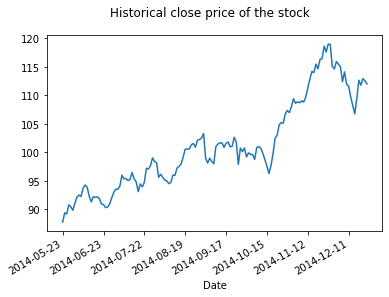

In [7]:
close_price.plot(subplots=True, title='Historical close price of the stock')

# Check Stationarity
We check the stationarity graphically and with the use of Dickey-Fuller test

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    
    
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

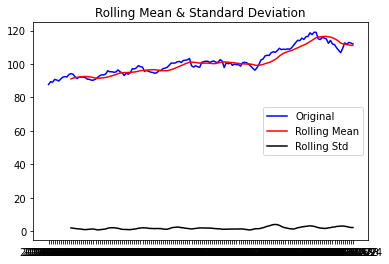

Results of Dickey-Fuller Test:
Test Statistic                  -1.230305
p-value                          0.660425
#Lags Used                       0.000000
Number of Observations Used    149.000000
Critical Value (1%)             -3.475018
Critical Value (5%)             -2.881141
Critical Value (10%)            -2.577221
dtype: float64


In [9]:
test_stationarity(close_price)

# Here we reduce the  trend

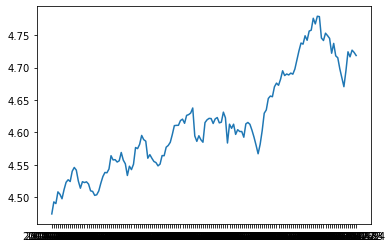

In [10]:
ts_log = np.log(close_price)
plt.plot(ts_log)

# Moving average

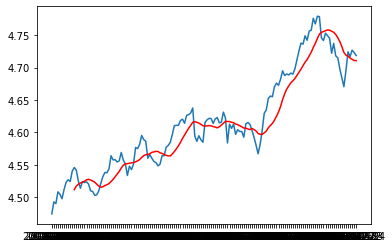

In [11]:
moving_avg = pd.Series(ts_log).rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [12]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Date
2014-05-23         NaN
2014-05-27         NaN
2014-05-28         NaN
2014-05-29         NaN
2014-05-30         NaN
2014-06-02         NaN
2014-06-03         NaN
2014-06-04         NaN
2014-06-05         NaN
2014-06-06         NaN
2014-06-09         NaN
2014-06-10    0.034288
Name: Close, dtype: float64

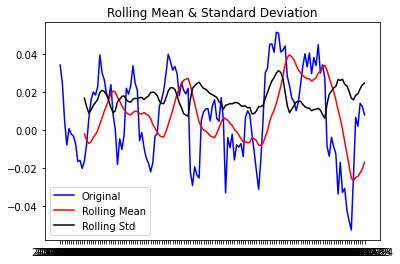

Results of Dickey-Fuller Test:
Test Statistic                  -3.326998
p-value                          0.013714
#Lags Used                       0.000000
Number of Observations Used    138.000000
Critical Value (1%)             -3.478648
Critical Value (5%)             -2.882722
Critical Value (10%)            -2.578065
dtype: float64


In [13]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

# Eliminating Trend and Seasonality

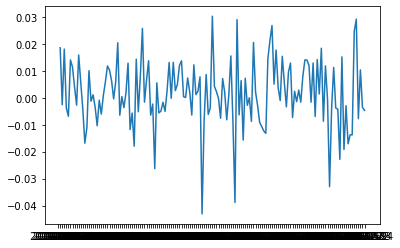

In [14]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

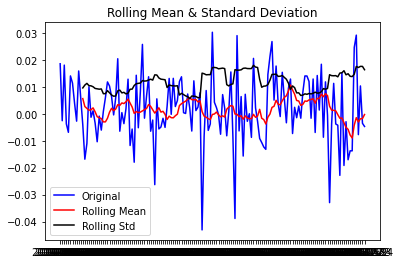

Results of Dickey-Fuller Test:
Test Statistic                -1.218232e+01
p-value                        1.342799e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.480000e+02
Critical Value (1%)           -3.475325e+00
Critical Value (5%)           -2.881275e+00
Critical Value (10%)          -2.577293e+00
dtype: float64


In [15]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)


# Decomposing

# Forecasting a Time Series

In [16]:
from statsmodels.tsa.stattools import acf, pacf

In [17]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

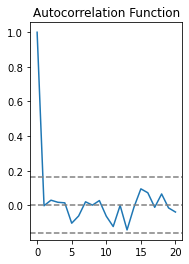

In [18]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

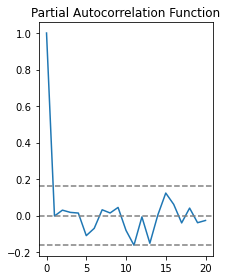

In [19]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [20]:
from statsmodels.tsa.arima_model import ARIMA

# Autoregressive model

Text(0.5, 1.0, 'RSS: 0.0221')

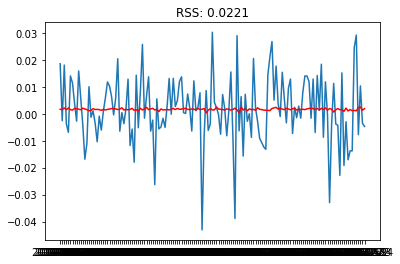

In [21]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

# Moving-average model

Text(0.5, 1.0, 'RSS: 0.0221')

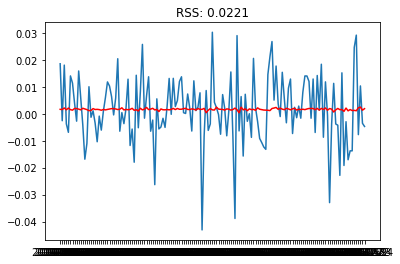

In [22]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

# Combined Model

Text(0.5, 1.0, 'RSS: 0.0209')

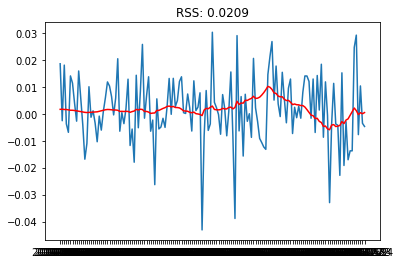

In [23]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

# Taking it back to original scale

In [24]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
2014-05-27    0.001635
2014-05-28    0.001685
2014-05-29    0.001583
2014-05-30    0.001573
2014-06-02    0.001419
dtype: float64

In [25]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Date
2014-05-27    0.001635
2014-05-28    0.003320
2014-05-29    0.004903
2014-05-30    0.006476
2014-06-02    0.007895
dtype: float64

In [26]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
2014-05-23    4.474296
2014-05-27    4.475931
2014-05-28    4.477616
2014-05-29    4.479199
2014-05-30    4.480772
dtype: float64

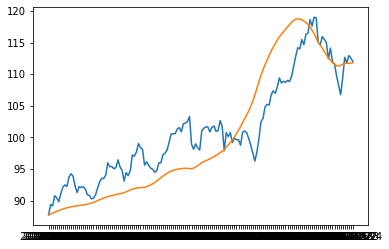

In [27]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(close_price)
plt.plot(predictions_ARIMA)
# plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

Here we save the prediction to excel, we commented it out when we finished the experiments

In [28]:
# predictions_ARIMA.to_excel('output'+name+'.xlsx', engine='xlsxwriter')

In [29]:
final=pd.read_csv("C:\\Users\\KILDE\\Desktop\\vxk969\\final3.csv")

In [30]:
predictionss = final['Pred']
predictionss.index = final['Date']
predictionss.head()

Date
09-06-08    25.944286
10-06-08    25.820539
11-06-08    25.619237
12-06-08    25.466496
13-06-08    25.572236
Name: Pred, dtype: float64

In [31]:
real = final['Close']
real.index = final['Date']

# Here is the clossing price and the ARIMA model predictions in on plot

Text(0.5, 1.0, 'Apple Stock prediction with ARIMA')

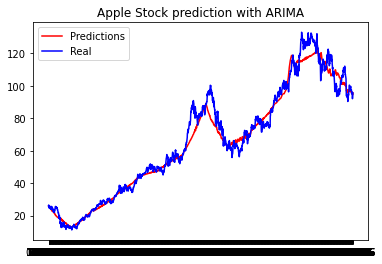

In [32]:
plt.plot(predictionss,color='Red', label='Predictions')
plt.plot(real,color='Blue', label='Real')
plt.legend(loc='best')
plt.title('Apple Stock prediction with ARIMA')